In [1]:
## Notebook env: gedi (R kernel)
## GEDI pt.2 - runs GEDI to find spliced/unspliced ratio of genes across perturbations

## get the unspliced and spliced counts mtxs for each of miR_1, miR_2, miR_3
## combine all unspliced mtxs and alle spliced mtxs into two final mtxs (save with scanpy)
## read into R the two mtxs with scrattch.io::read_loom_dgCMatrix, input into gedi

## then take imputed psi values (spliced/unspliced counts -- RNA stability) from gedi model and make violin plots of them as drawn in RM2

In [2]:
.libPaths('/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

## install packages below into env if not already installed
## remotes::install_github('csglab/GEDI', lib = '/home/ssobti/projects/mir_tud/packages/gedi_R_pkgs')

library(HDF5Array)
library(ggplot2)
library(Matrix)
library(RColorBrewer)
library(uwot)
library(GEDI)
library(SeuratWrappers)
set.seed(43)

Loading required package: DelayedArray



Loading required package: stats4



Loading required package: Matrix



Loading required package: BiocGenerics




Attaching package: ‘BiocGenerics’




The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs




The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min




Loading required package: MatrixGenerics



Loading required package: matrixStats




Attaching package: ‘MatrixGenerics’




The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    rowWeightedMads, rowWeightedMeans, rowWeightedMedians,
    rowWeightedSds, rowWeig

Loading required package: S4Vectors




Attaching package: ‘S4Vectors’




The following objects are masked from ‘package:Matrix’:

    expand, unname




The following object is masked from ‘package:utils’:

    findMatches




The following objects are masked from ‘package:base’:

    expand.grid, I, unname




Loading required package: IRanges



Loading required package: S4Arrays



Loading required package: abind




Attaching package: ‘S4Arrays’




The following object is masked from ‘package:abind’:

    abind




The following object is masked from ‘package:base’:

    rowsum




Loading required package: SparseArray




Attaching package: ‘DelayedArray’




The following objects are masked from ‘package:base’:

    apply, scale, sweep




Loading required package: rhdf5




Attaching package: ‘HDF5Array’




The following object is masked from ‘package:rhdf5’:

    h5ls




In [3]:
## load loom files
miR_1 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_1/miR_1.loom')
miR_2 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_2/miR_2.loom')
miR_3 = ReadVelocity(file = '/home/ssobti/projects/mir_tud/output_data/splicing/velocyto/miR_3/miR_3.loom')

In [4]:
spliced = list(miR_1[['spliced']], miR_2[['spliced']], miR_3[['spliced']])
unspliced = list(miR_1[['unspliced']], miR_2[['unspliced']], miR_3[['unspliced']])

In [5]:
## combine spliced and unspliced counts into two final mtxs
## the gedi model will take sample labels within each of the two mtxs
spliced_combined = cbind(spliced[[1]], spliced[[2]], spliced[[3]])
unspliced_combined = cbind(unspliced[[1]], unspliced[[2]], unspliced[[3]])

## filter out genes with low median UMIs from the expression data
filtered_meta_data <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_meta.csv', header = TRUE)
rownames(filtered_meta_data) <- filtered_meta_data$X
filtered_meta_data$guide <- as.character(filtered_meta_data$guide)

raw_genes <- read.csv('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_gene_names.csv', header = FALSE)
raw_genes <- raw_genes$V2[-1]
raw_genes <- as.character(raw_genes)

filtered_raw_mtx <- readMM('/home/ssobti/projects/mir_tud/010523_filtered_data/miR_normalized_data.mtx')
filtered_raw_mtx = as(filtered_raw_mtx, 'dgCMatrix')
rownames(filtered_raw_mtx) = raw_genes
colnames(filtered_raw_mtx) = rownames(filtered_meta_data)
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
genes_to_keep = as.numeric(medians) >= 0.01
filtered_raw_mtx <- filtered_raw_mtx[genes_to_keep,]

spliced_combined = spliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(spliced_combined)],]
unspliced_combined = unspliced_combined[rownames(filtered_raw_mtx)[rownames(filtered_raw_mtx) %in% rownames(unspliced_combined)],]

## filter out low splice/unspliced count cells and low count genes
filtered_cols <- which(log10(colSums(spliced_combined)) > 3 & log10(colSums(unspliced_combined)) > 3)
filtered_rows <- which(rowSums(spliced_combined) > 50 & rowSums(unspliced_combined) > 50)
spliced_combined = spliced_combined[filtered_rows, filtered_cols]
unspliced_combined = unspliced_combined[filtered_rows, filtered_cols]

## get sample identity
sample_identity = stringr::str_sub(colnames(spliced_combined), start = 1, end = 5)


'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [6]:
## percent of cells that remain after filtering
100*length(filtered_cols) / ncol(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

## percent of genes that remain after filtering
100*length(filtered_rows) / nrow(cbind(spliced[[1]], spliced[[2]], spliced[[3]]))

[1] 96.41238

[1] 17.93667

Warning message:
“Removed 6436 rows containing non-finite outside the scale range (`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


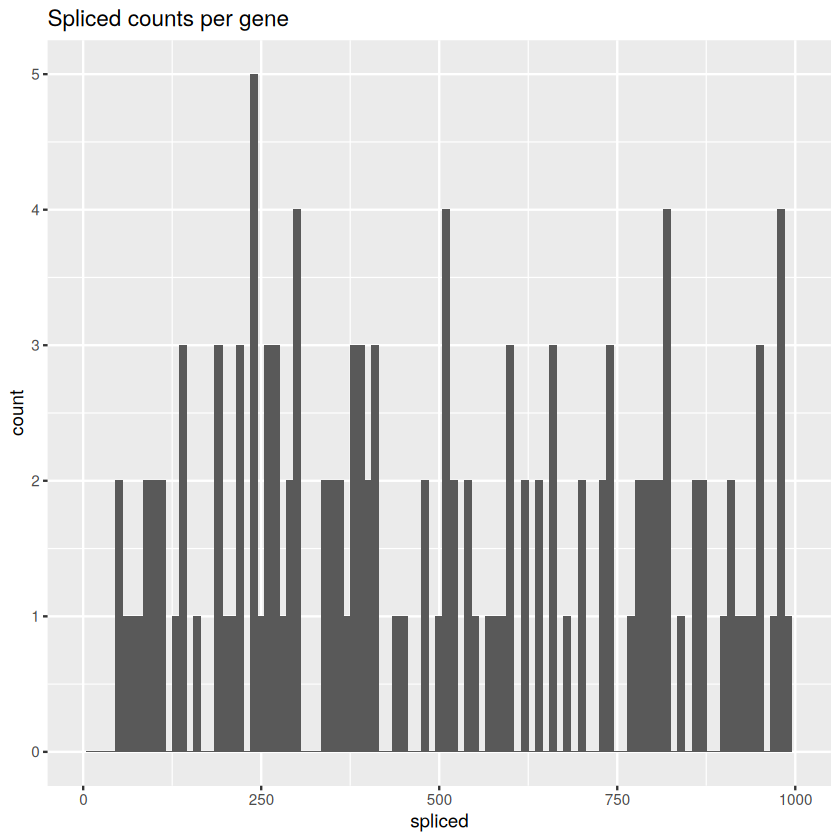

In [7]:
df = data.frame(spliced = rowSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 1000) + ggtitle('Spliced counts per gene')

Warning message:
“Removed 41640 rows containing non-finite outside the scale range
(`stat_bin()`).”


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


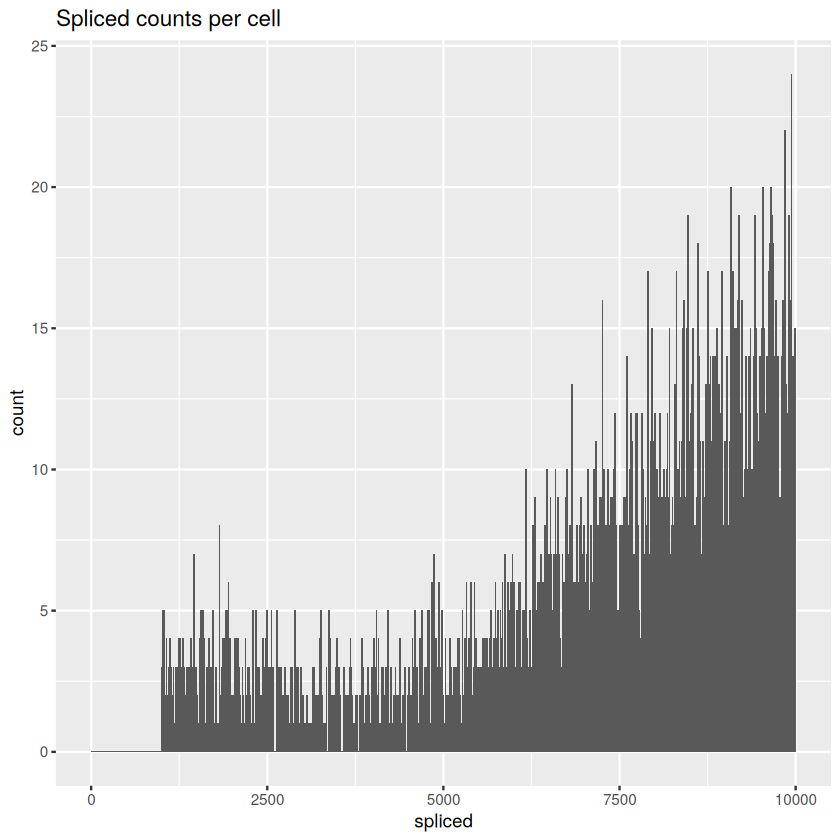

In [8]:
df2 = data.frame(spliced = colSums(spliced_combined[rowSums(spliced_combined) > 50, colSums(spliced_combined) > 50]))
ggplot(df2, aes(x = spliced)) + geom_histogram(binwidth = 10) + xlim(0, 10000) + ggtitle('Spliced counts per cell')

In [9]:
rm(miR_1, miR_2, miR_3, spliced, unspliced, filtered_cols, filtered_rows, df, df2, filtered_raw_mtx)

In [10]:
## Set up GEDI model
model <- new("GEDI") # Initialize GEDI object
model$setup(Samples = sample_identity, # Vector indicating which sample belongs to each cell
            colData = data.frame(cell_names = colnames(spliced_combined)), # Metadata (optional)
            M = list(spliced_combined, unspliced_combined), # Expression data as a list of two matrices, in which case they are considered as paired observations whose log-ratio must be modelled.
            K = 20, # Number of latent variables to use
            mode = "Bsphere", # Modes to use: Either Bsphere (hyperellipsoid) or Bl2 (hyperplane)
            oi_shrinkage = 0.001 # Shrinkage multiplier for oi. In here we use 0.001, to better accommodated the mean abundance differences that exist between multiple scRNA-seq technologies.
            ) 
model$initialize.LVs(randomSeed = 1) # initialize LVs
model$optimize(iterations = 150) # run model with 150 iterations
saveRDS(model, file = "/home/ssobti/projects/mir_tud/output_data/splicing/miR/miR_gedi_model.rds") # Saving output model

Setting up the GEDI model...



Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.3 GiB”


Initializing LVs...



  Initializing oi...



  Performing initial decompsition of Y...



Performing block coordinate descent optimization...



  Iteration 1/150 (total 1)...



2.677482 
1 
Mean(o): -0.4809108 ; Var(o): 1.761535 ; Var(si): 0.001929541 


  Iteration 2/150 (total 2)...



2.25979 
1 
Mean(o): -0.4809718 ; Var(o): 2.084354 ; Var(si): 0.004615185 


  Iteration 3/150 (total 3)...



1.981224 
1 
Mean(o): -0.4810125 ; Var(o): 2.374428 ; Var(si): 0.007978855 


  Iteration 4/150 (total 4)...



1.785478 
1 
Mean(o): -0.4810441 ; Var(o): 2.631658 ; Var(si): 0.01161112 


  Iteration 5/150 (total 5)...



1.639232 
1 
Mean(o): -0.4810706 ; Var(o): 2.863374 ; Var(si): 0.01449443 


  Iteration 6/150 (total 6)...



1.521763 
1 
Mean(o): -0.4810952 ; Var(o): 3.081429 ; Var(si): 0.01621314 


  Iteration 7/150 (total 7)...



1.420745 
1 
Mean(o): -0.4811197 ; Var(o): 3.297692 ; Var(si): 0.01709303 


  Iteration 8/150 (total 8)...



1.32902 
1 
Mean(o): -0.4811449 ; Var(o): 3.522614 ; Var(si): 0.01765415 


  Iteration 9/150 (total 9)...



1.243721 
1 
Mean(o): -0.4811708 ; Var(o): 3.761692 ; Var(si): 0.01836264 


  Iteration 10/150 (total 10)...



1.164669 
1 
Mean(o): -0.4811969 ; Var(o): 4.01464 ; Var(si): 0.01938448 


  Iteration 11/150 (total 11)...



1.092247 
1 
Mean(o): -0.4812226 ; Var(o): 4.278566 ; Var(si): 0.02063092 


  Iteration 12/150 (total 12)...



1.026702 
1 
Mean(o): -0.4812475 ; Var(o): 4.549527 ; Var(si): 0.02195085 


  Iteration 13/150 (total 13)...



0.967898 
1 
Mean(o): -0.4812715 ; Var(o): 4.823797 ; Var(si): 0.02322045 


  Iteration 14/150 (total 14)...



0.9153737 
1 
Mean(o): -0.4812948 ; Var(o): 5.098485 ; Var(si): 0.02436589 


  Iteration 15/150 (total 15)...



0.8685182 
1 
Mean(o): -0.4813173 ; Var(o): 5.371454 ; Var(si): 0.02536758 


  Iteration 16/150 (total 16)...



0.8266837 
1 
Mean(o): -0.4813394 ; Var(o): 5.64119 ; Var(si): 0.02624715 


  Iteration 17/150 (total 17)...



0.7892378 
1 
Mean(o): -0.4813611 ; Var(o): 5.906743 ; Var(si): 0.0270432 


  Iteration 18/150 (total 18)...



0.7555962 
1 
Mean(o): -0.4813825 ; Var(o): 6.16762 ; Var(si): 0.0277918 


  Iteration 19/150 (total 19)...



0.7252416 
1 
Mean(o): -0.4814037 ; Var(o): 6.423635 ; Var(si): 0.0285189 


  Iteration 20/150 (total 20)...



0.6977291 
1 
Mean(o): -0.4814246 ; Var(o): 6.674782 ; Var(si): 0.02924028 


  Iteration 21/150 (total 21)...



0.6726821 
1 
Mean(o): -0.4814452 ; Var(o): 6.92115 ; Var(si): 0.02996413 


  Iteration 22/150 (total 22)...



0.6497837 
1 
Mean(o): -0.4814657 ; Var(o): 7.162871 ; Var(si): 0.03069352 


  Iteration 23/150 (total 23)...



0.6287671 
1 
Mean(o): -0.4814858 ; Var(o): 7.400091 ; Var(si): 0.03142857 


  Iteration 24/150 (total 24)...



0.6094079 
1 
Mean(o): -0.4815058 ; Var(o): 7.632957 ; Var(si): 0.03216798 


  Iteration 25/150 (total 25)...



0.5915155 
1 
Mean(o): -0.4815255 ; Var(o): 7.861611 ; Var(si): 0.03291001 


  Iteration 26/150 (total 26)...



0.574928 
1 
Mean(o): -0.4815449 ; Var(o): 8.086184 ; Var(si): 0.03365299 


  Iteration 27/150 (total 27)...



0.5595066 
1 
Mean(o): -0.4815642 ; Var(o): 8.3068 ; Var(si): 0.03439553 


  Iteration 28/150 (total 28)...



0.5451317 
1 
Mean(o): -0.4815832 ; Var(o): 8.523574 ; Var(si): 0.03513652 


  Iteration 29/150 (total 29)...



0.5316995 
1 
Mean(o): -0.481602 ; Var(o): 8.736616 ; Var(si): 0.03587511 


  Iteration 30/150 (total 30)...



0.5191198 
1 
Mean(o): -0.4816205 ; Var(o): 8.94603 ; Var(si): 0.0366106 


  Iteration 31/150 (total 31)...



0.5073133 
1 
Mean(o): -0.4816389 ; Var(o): 9.151916 ; Var(si): 0.0373424 


  Iteration 32/150 (total 32)...



0.4962104 
1 
Mean(o): -0.4816571 ; Var(o): 9.35437 ; Var(si): 0.03807002 


  Iteration 33/150 (total 33)...



0.4857495 
1 
Mean(o): -0.4816751 ; Var(o): 9.553488 ; Var(si): 0.03879301 


  Iteration 34/150 (total 34)...



0.4758761 
1 
Mean(o): -0.4816929 ; Var(o): 9.749358 ; Var(si): 0.03951101 


  Iteration 35/150 (total 35)...



0.4665415 
1 
Mean(o): -0.4817105 ; Var(o): 9.942068 ; Var(si): 0.04022367 


  Iteration 36/150 (total 36)...



0.4577025 
1 
Mean(o): -0.4817279 ; Var(o): 10.1317 ; Var(si): 0.04093074 


  Iteration 37/150 (total 37)...



0.4493202 
1 
Mean(o): -0.4817452 ; Var(o): 10.31834 ; Var(si): 0.04163199 


  Iteration 38/150 (total 38)...



0.4413597 
1 
Mean(o): -0.4817623 ; Var(o): 10.50206 ; Var(si): 0.04232724 


  Iteration 39/150 (total 39)...



0.4337896 
1 
Mean(o): -0.4817793 ; Var(o): 10.68294 ; Var(si): 0.04301637 


  Iteration 40/150 (total 40)...



0.4265817 
1 
Mean(o): -0.4817961 ; Var(o): 10.86106 ; Var(si): 0.04369927 


  Iteration 41/150 (total 41)...



0.4197101 
1 
Mean(o): -0.4818128 ; Var(o): 11.03647 ; Var(si): 0.04437589 


  Iteration 42/150 (total 42)...



0.4131516 
1 
Mean(o): -0.4818293 ; Var(o): 11.20926 ; Var(si): 0.04504616 


  Iteration 43/150 (total 43)...



0.406885 
1 
Mean(o): -0.4818457 ; Var(o): 11.37948 ; Var(si): 0.04571007 


  Iteration 44/150 (total 44)...



0.400891 
1 
Mean(o): -0.481862 ; Var(o): 11.5472 ; Var(si): 0.04636761 


  Iteration 45/150 (total 45)...



0.395152 
1 
Mean(o): -0.4818781 ; Var(o): 11.71249 ; Var(si): 0.04701877 


  Iteration 46/150 (total 46)...



0.3896518 
1 
Mean(o): -0.4818941 ; Var(o): 11.87539 ; Var(si): 0.04766358 


  Iteration 47/150 (total 47)...



0.3843756 
1 
Mean(o): -0.48191 ; Var(o): 12.03596 ; Var(si): 0.04830206 


  Iteration 48/150 (total 48)...



0.37931 
1 
Mean(o): -0.4819258 ; Var(o): 12.19427 ; Var(si): 0.04893423 


  Iteration 49/150 (total 49)...



0.3744423 
1 
Mean(o): -0.4819415 ; Var(o): 12.35035 ; Var(si): 0.04956012 


  Iteration 50/150 (total 50)...



0.3697611 
1 
Mean(o): -0.4819571 ; Var(o): 12.50426 ; Var(si): 0.05017979 


  Iteration 51/150 (total 51)...



0.3652558 
1 
Mean(o): -0.4819725 ; Var(o): 12.65606 ; Var(si): 0.05079326 


  Iteration 52/150 (total 52)...



0.3609166 
1 
Mean(o): -0.4819879 ; Var(o): 12.80577 ; Var(si): 0.05140059 


  Iteration 53/150 (total 53)...



0.3567344 
1 
Mean(o): -0.4820032 ; Var(o): 12.95345 ; Var(si): 0.05200183 


  Iteration 54/150 (total 54)...



0.3527007 
1 
Mean(o): -0.4820184 ; Var(o): 13.09915 ; Var(si): 0.05259702 


  Iteration 55/150 (total 55)...



0.3488078 
1 
Mean(o): -0.4820335 ; Var(o): 13.24289 ; Var(si): 0.05318622 


  Iteration 56/150 (total 56)...



0.3450484 
1 
Mean(o): -0.4820485 ; Var(o): 13.38473 ; Var(si): 0.05376948 


  Iteration 57/150 (total 57)...



0.3414156 
1 
Mean(o): -0.4820634 ; Var(o): 13.52469 ; Var(si): 0.05434685 


  Iteration 58/150 (total 58)...



0.3379032 
1 
Mean(o): -0.4820782 ; Var(o): 13.66282 ; Var(si): 0.05491839 


  Iteration 59/150 (total 59)...



0.3345053 
1 
Mean(o): -0.482093 ; Var(o): 13.79915 ; Var(si): 0.05548414 


  Iteration 60/150 (total 60)...



0.3312164 
1 
Mean(o): -0.4821076 ; Var(o): 13.93372 ; Var(si): 0.05604417 


  Iteration 61/150 (total 61)...



0.3280312 
1 
Mean(o): -0.4821222 ; Var(o): 14.06657 ; Var(si): 0.05659854 


  Iteration 62/150 (total 62)...



0.3249449 
1 
Mean(o): -0.4821368 ; Var(o): 14.19771 ; Var(si): 0.05714728 


  Iteration 63/150 (total 63)...



0.321953 
1 
Mean(o): -0.4821512 ; Var(o): 14.32719 ; Var(si): 0.05769048 


  Iteration 64/150 (total 64)...



0.3190512 
1 
Mean(o): -0.4821656 ; Var(o): 14.45505 ; Var(si): 0.05822818 


  Iteration 65/150 (total 65)...



0.3162355 
1 
Mean(o): -0.4821799 ; Var(o): 14.5813 ; Var(si): 0.05876044 


  Iteration 66/150 (total 66)...



0.313502 
1 
Mean(o): -0.4821942 ; Var(o): 14.70598 ; Var(si): 0.05928733 


  Iteration 67/150 (total 67)...



0.3108473 
1 
Mean(o): -0.4822084 ; Var(o): 14.82911 ; Var(si): 0.05980891 


  Iteration 68/150 (total 68)...



0.308268 
1 
Mean(o): -0.4822225 ; Var(o): 14.95074 ; Var(si): 0.06032525 


  Iteration 69/150 (total 69)...



0.3057608 
1 
Mean(o): -0.4822366 ; Var(o): 15.07088 ; Var(si): 0.06083639 


  Iteration 70/150 (total 70)...



0.3033229 
1 
Mean(o): -0.4822506 ; Var(o): 15.18955 ; Var(si): 0.06134242 


  Iteration 71/150 (total 71)...



0.3009513 
1 
Mean(o): -0.4822646 ; Var(o): 15.3068 ; Var(si): 0.06184339 


  Iteration 72/150 (total 72)...



0.2986433 
1 
Mean(o): -0.4822785 ; Var(o): 15.42264 ; Var(si): 0.06233937 


  Iteration 73/150 (total 73)...



0.2963966 
1 
Mean(o): -0.4822923 ; Var(o): 15.5371 ; Var(si): 0.06283042 


  Iteration 74/150 (total 74)...



0.2942085 
1 
Mean(o): -0.4823061 ; Var(o): 15.6502 ; Var(si): 0.0633166 


  Iteration 75/150 (total 75)...



0.292077 
1 
Mean(o): -0.4823198 ; Var(o): 15.76197 ; Var(si): 0.06379798 


  Iteration 76/150 (total 76)...



0.2899997 
1 
Mean(o): -0.4823335 ; Var(o): 15.87243 ; Var(si): 0.06427463 


  Iteration 77/150 (total 77)...



0.2879747 
1 
Mean(o): -0.4823472 ; Var(o): 15.9816 ; Var(si): 0.06474659 


  Iteration 78/150 (total 78)...



0.286 
1 
Mean(o): -0.4823608 ; Var(o): 16.08951 ; Var(si): 0.06521394 


  Iteration 79/150 (total 79)...



0.2840737 
1 
Mean(o): -0.4823743 ; Var(o): 16.19617 ; Var(si): 0.06567674 


  Iteration 80/150 (total 80)...



0.2821941 
1 
Mean(o): -0.4823878 ; Var(o): 16.30161 ; Var(si): 0.06613504 


  Iteration 81/150 (total 81)...



0.2803595 
1 
Mean(o): -0.4824013 ; Var(o): 16.40586 ; Var(si): 0.0665889 


  Iteration 82/150 (total 82)...



0.2785683 
1 
Mean(o): -0.4824147 ; Var(o): 16.50891 ; Var(si): 0.06703839 


  Iteration 83/150 (total 83)...



0.2768189 
1 
Mean(o): -0.4824281 ; Var(o): 16.61081 ; Var(si): 0.06748355 


  Iteration 84/150 (total 84)...



0.27511 
1 
Mean(o): -0.4824415 ; Var(o): 16.71157 ; Var(si): 0.06792445 


  Iteration 85/150 (total 85)...



0.2734402 
1 
Mean(o): -0.4824548 ; Var(o): 16.8112 ; Var(si): 0.06836114 


  Iteration 86/150 (total 86)...



0.2718081 
1 
Mean(o): -0.482468 ; Var(o): 16.90973 ; Var(si): 0.06879367 


  Iteration 87/150 (total 87)...



0.2702124 
1 
Mean(o): -0.4824812 ; Var(o): 17.00717 ; Var(si): 0.0692221 


  Iteration 88/150 (total 88)...



0.268652 
1 
Mean(o): -0.4824944 ; Var(o): 17.10354 ; Var(si): 0.06964648 


  Iteration 89/150 (total 89)...



0.2671256 
1 
Mean(o): -0.4825076 ; Var(o): 17.19886 ; Var(si): 0.07006687 


  Iteration 90/150 (total 90)...



0.2656323 
1 
Mean(o): -0.4825207 ; Var(o): 17.29314 ; Var(si): 0.0704833 


  Iteration 91/150 (total 91)...



0.2641709 
1 
Mean(o): -0.4825338 ; Var(o): 17.38641 ; Var(si): 0.07089585 


  Iteration 92/150 (total 92)...



0.2627404 
1 
Mean(o): -0.4825468 ; Var(o): 17.47867 ; Var(si): 0.07130454 


  Iteration 93/150 (total 93)...



0.2613399 
1 
Mean(o): -0.4825598 ; Var(o): 17.56994 ; Var(si): 0.07170943 


  Iteration 94/150 (total 94)...



0.2599685 
1 
Mean(o): -0.4825728 ; Var(o): 17.66024 ; Var(si): 0.07211058 


  Iteration 95/150 (total 95)...



0.2586251 
1 
Mean(o): -0.4825858 ; Var(o): 17.74958 ; Var(si): 0.07250802 


  Iteration 96/150 (total 96)...



0.2573091 
1 
Mean(o): -0.4825987 ; Var(o): 17.83799 ; Var(si): 0.0729018 


  Iteration 97/150 (total 97)...



0.2560195 
1 
Mean(o): -0.4826116 ; Var(o): 17.92546 ; Var(si): 0.07329197 


  Iteration 98/150 (total 98)...



0.2547556 
1 
Mean(o): -0.4826244 ; Var(o): 18.01202 ; Var(si): 0.07367857 


  Iteration 99/150 (total 99)...



0.2535166 
1 
Mean(o): -0.4826373 ; Var(o): 18.09768 ; Var(si): 0.07406165 


  Iteration 100/150 (total 100)...



0.2523018 
1 
Mean(o): -0.4826501 ; Var(o): 18.18245 ; Var(si): 0.07444125 


  Iteration 101/150 (total 101)...



0.2511106 
1 
Mean(o): -0.4826628 ; Var(o): 18.26634 ; Var(si): 0.0748174 


  Iteration 102/150 (total 102)...



0.2499421 
1 
Mean(o): -0.4826756 ; Var(o): 18.34938 ; Var(si): 0.07519017 


  Iteration 103/150 (total 103)...



0.2487959 
1 
Mean(o): -0.4826883 ; Var(o): 18.43157 ; Var(si): 0.07555957 


  Iteration 104/150 (total 104)...



0.2476712 
1 
Mean(o): -0.482701 ; Var(o): 18.51292 ; Var(si): 0.07592566 


  Iteration 105/150 (total 105)...



0.2465675 
1 
Mean(o): -0.4827136 ; Var(o): 18.59345 ; Var(si): 0.07628848 


  Iteration 106/150 (total 106)...



0.2454841 
1 
Mean(o): -0.4827263 ; Var(o): 18.67317 ; Var(si): 0.07664806 


  Iteration 107/150 (total 107)...



0.2444206 
1 
Mean(o): -0.4827389 ; Var(o): 18.75208 ; Var(si): 0.07700444 


  Iteration 108/150 (total 108)...



0.2433764 
1 
Mean(o): -0.4827515 ; Var(o): 18.83021 ; Var(si): 0.07735767 


  Iteration 109/150 (total 109)...



0.242351 
1 
Mean(o): -0.482764 ; Var(o): 18.90756 ; Var(si): 0.07770777 


  Iteration 110/150 (total 110)...



0.2413439 
1 
Mean(o): -0.4827766 ; Var(o): 18.98414 ; Var(si): 0.07805479 


  Iteration 111/150 (total 111)...



0.2403546 
1 
Mean(o): -0.4827891 ; Var(o): 19.05997 ; Var(si): 0.07839876 


  Iteration 112/150 (total 112)...



0.2393827 
1 
Mean(o): -0.4828016 ; Var(o): 19.13505 ; Var(si): 0.07873971 


  Iteration 113/150 (total 113)...



0.2384276 
1 
Mean(o): -0.4828141 ; Var(o): 19.2094 ; Var(si): 0.07907769 


  Iteration 114/150 (total 114)...



0.2374891 
1 
Mean(o): -0.4828265 ; Var(o): 19.28302 ; Var(si): 0.07941273 


  Iteration 115/150 (total 115)...



0.2365665 
1 
Mean(o): -0.482839 ; Var(o): 19.35593 ; Var(si): 0.07974485 


  Iteration 116/150 (total 116)...



0.2356597 
1 
Mean(o): -0.4828514 ; Var(o): 19.42813 ; Var(si): 0.08007411 


  Iteration 117/150 (total 117)...



0.234768 
1 
Mean(o): -0.4828638 ; Var(o): 19.49963 ; Var(si): 0.08040051 


  Iteration 118/150 (total 118)...



0.2338913 
1 
Mean(o): -0.4828761 ; Var(o): 19.57045 ; Var(si): 0.08072411 


  Iteration 119/150 (total 119)...



0.2330291 
1 
Mean(o): -0.4828885 ; Var(o): 19.6406 ; Var(si): 0.08104494 


  Iteration 120/150 (total 120)...



0.2321811 
1 
Mean(o): -0.4829008 ; Var(o): 19.71007 ; Var(si): 0.08136301 


  Iteration 121/150 (total 121)...



0.2313469 
1 
Mean(o): -0.4829131 ; Var(o): 19.77888 ; Var(si): 0.08167838 


  Iteration 122/150 (total 122)...



0.2305262 
1 
Mean(o): -0.4829254 ; Var(o): 19.84705 ; Var(si): 0.08199105 


  Iteration 123/150 (total 123)...



0.2297187 
1 
Mean(o): -0.4829377 ; Var(o): 19.91457 ; Var(si): 0.08230108 


  Iteration 124/150 (total 124)...



0.228924 
1 
Mean(o): -0.4829499 ; Var(o): 19.98146 ; Var(si): 0.08260848 


  Iteration 125/150 (total 125)...



0.2281419 
1 
Mean(o): -0.4829622 ; Var(o): 20.04772 ; Var(si): 0.08291329 


  Iteration 126/150 (total 126)...



0.2273721 
1 
Mean(o): -0.4829744 ; Var(o): 20.11337 ; Var(si): 0.08321553 


  Iteration 127/150 (total 127)...



0.2266143 
1 
Mean(o): -0.4829866 ; Var(o): 20.1784 ; Var(si): 0.08351524 


  Iteration 128/150 (total 128)...



0.2258683 
1 
Mean(o): -0.4829988 ; Var(o): 20.24284 ; Var(si): 0.08381243 


  Iteration 129/150 (total 129)...



0.2251337 
1 
Mean(o): -0.4830109 ; Var(o): 20.30668 ; Var(si): 0.08410715 


  Iteration 130/150 (total 130)...



0.2244103 
1 
Mean(o): -0.4830231 ; Var(o): 20.36993 ; Var(si): 0.08439942 


  Iteration 131/150 (total 131)...



0.2236979 
1 
Mean(o): -0.4830352 ; Var(o): 20.4326 ; Var(si): 0.08468926 


  Iteration 132/150 (total 132)...



0.2229962 
1 
Mean(o): -0.4830473 ; Var(o): 20.49471 ; Var(si): 0.0849767 


  Iteration 133/150 (total 133)...



0.2223049 
1 
Mean(o): -0.4830594 ; Var(o): 20.55625 ; Var(si): 0.08526177 


  Iteration 134/150 (total 134)...



0.221624 
1 
Mean(o): -0.4830715 ; Var(o): 20.61723 ; Var(si): 0.08554449 


  Iteration 135/150 (total 135)...



0.220953 
1 
Mean(o): -0.4830836 ; Var(o): 20.67766 ; Var(si): 0.0858249 


  Iteration 136/150 (total 136)...



0.2202919 
1 
Mean(o): -0.4830956 ; Var(o): 20.73754 ; Var(si): 0.086103 


  Iteration 137/150 (total 137)...



0.2196404 
1 
Mean(o): -0.4831077 ; Var(o): 20.79689 ; Var(si): 0.08637884 


  Iteration 138/150 (total 138)...



0.2189983 
1 
Mean(o): -0.4831197 ; Var(o): 20.85571 ; Var(si): 0.08665244 


  Iteration 139/150 (total 139)...



0.2183655 
1 
Mean(o): -0.4831317 ; Var(o): 20.914 ; Var(si): 0.08692381 


  Iteration 140/150 (total 140)...



0.2177416 
1 
Mean(o): -0.4831437 ; Var(o): 20.97178 ; Var(si): 0.08719298 


  Iteration 141/150 (total 141)...



0.2171266 
1 
Mean(o): -0.4831557 ; Var(o): 21.02905 ; Var(si): 0.08745999 


  Iteration 142/150 (total 142)...



0.2165203 
1 
Mean(o): -0.4831677 ; Var(o): 21.08581 ; Var(si): 0.08772484 


  Iteration 143/150 (total 143)...



0.2159224 
1 
Mean(o): -0.4831796 ; Var(o): 21.14207 ; Var(si): 0.08798757 


  Iteration 144/150 (total 144)...



0.2153328 
1 
Mean(o): -0.4831915 ; Var(o): 21.19783 ; Var(si): 0.08824819 


  Iteration 145/150 (total 145)...



0.2147514 
1 
Mean(o): -0.4832035 ; Var(o): 21.25311 ; Var(si): 0.08850673 


  Iteration 146/150 (total 146)...



0.2141779 
1 
Mean(o): -0.4832154 ; Var(o): 21.30791 ; Var(si): 0.08876322 


  Iteration 147/150 (total 147)...



0.2136123 
1 
Mean(o): -0.4832273 ; Var(o): 21.36223 ; Var(si): 0.08901766 


  Iteration 148/150 (total 148)...



0.2130544 
1 
Mean(o): -0.4832392 ; Var(o): 21.41608 ; Var(si): 0.0892701 


  Iteration 149/150 (total 149)...



0.2125039 
1 
Mean(o): -0.483251 ; Var(o): 21.46947 ; Var(si): 0.08952053 


  Iteration 150/150 (total 150)...



0.2119609 
1 
Mean(o): -0.4832629 ; Var(o): 21.52239 ; Var(si): 0.089769 


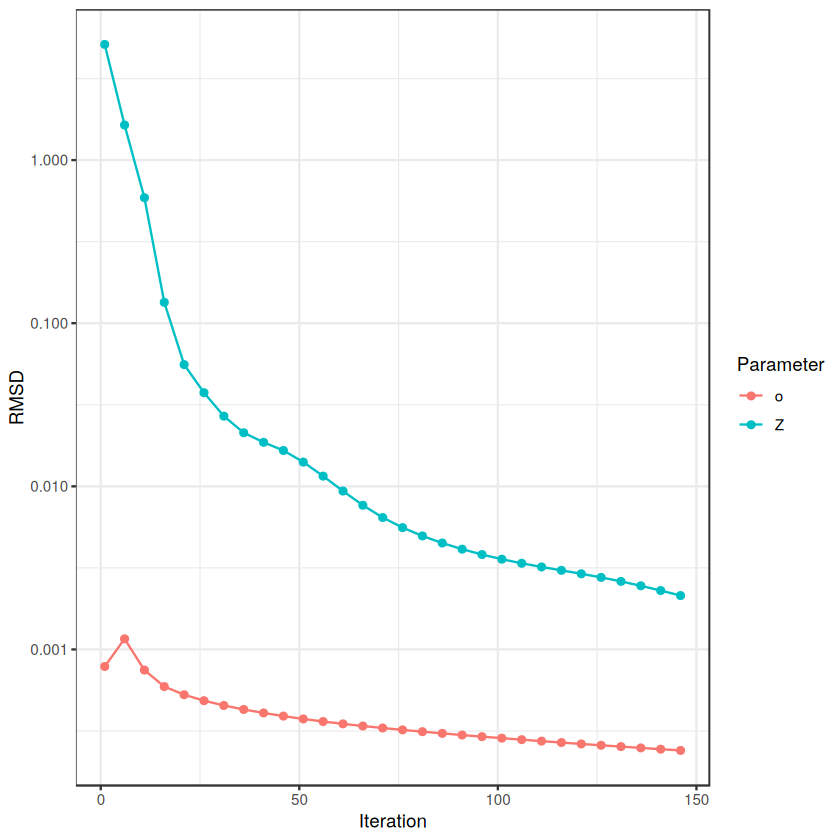

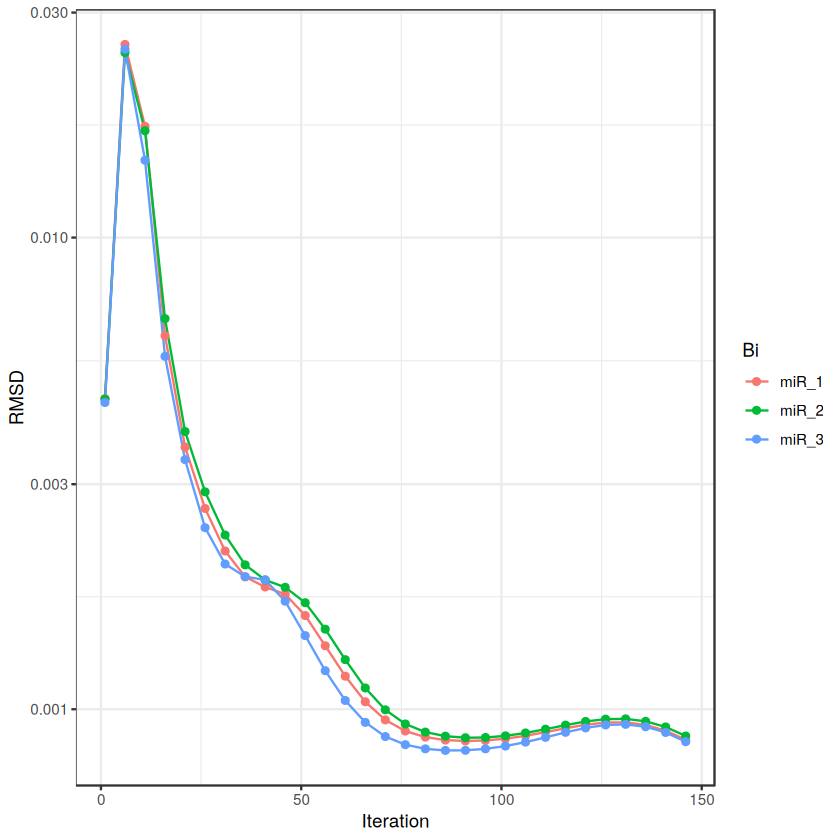

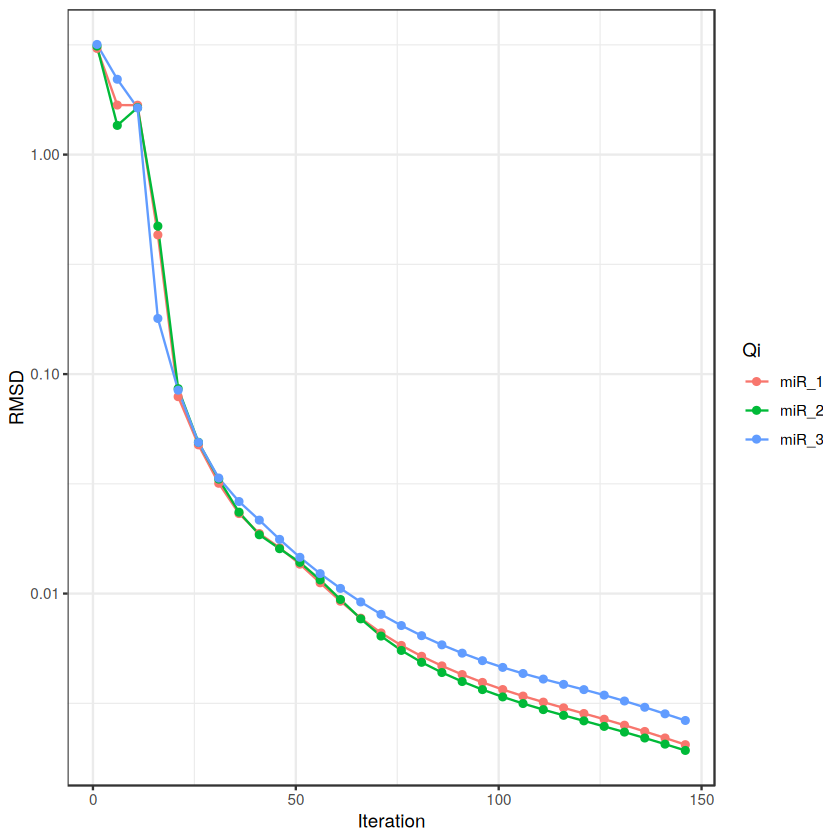

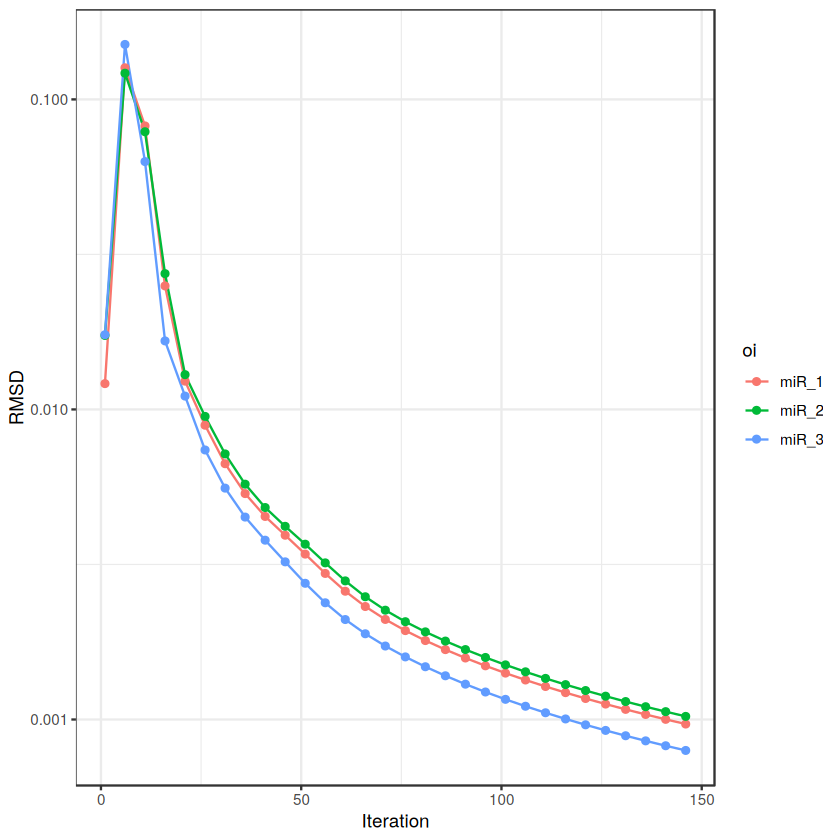

$ZAo

$Bi

$Qi

$oi

$si

$Rk
NULL

$sigma2


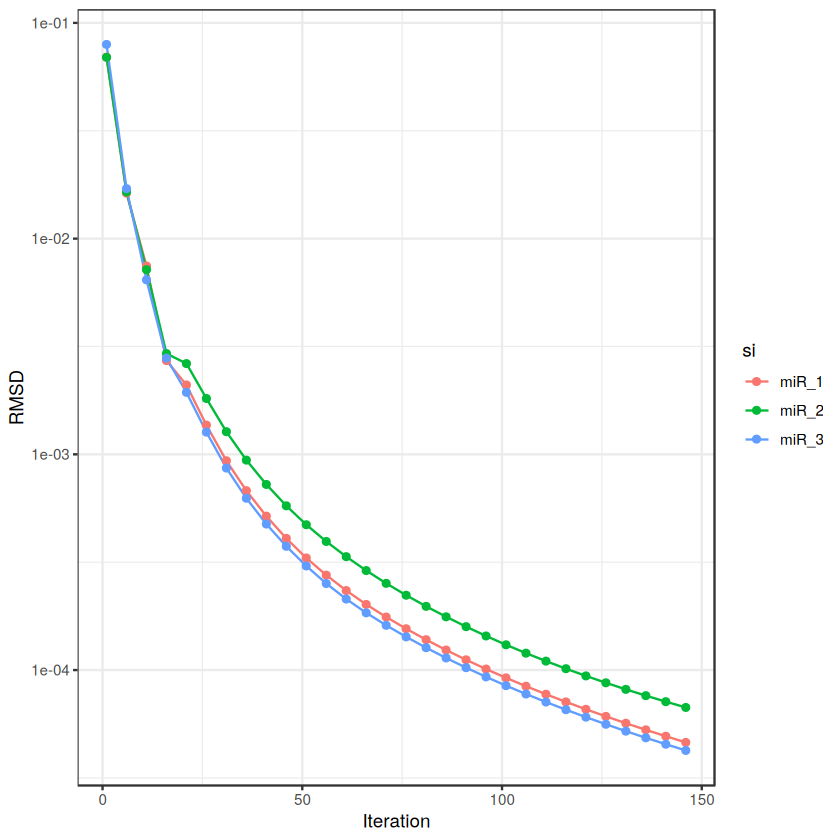

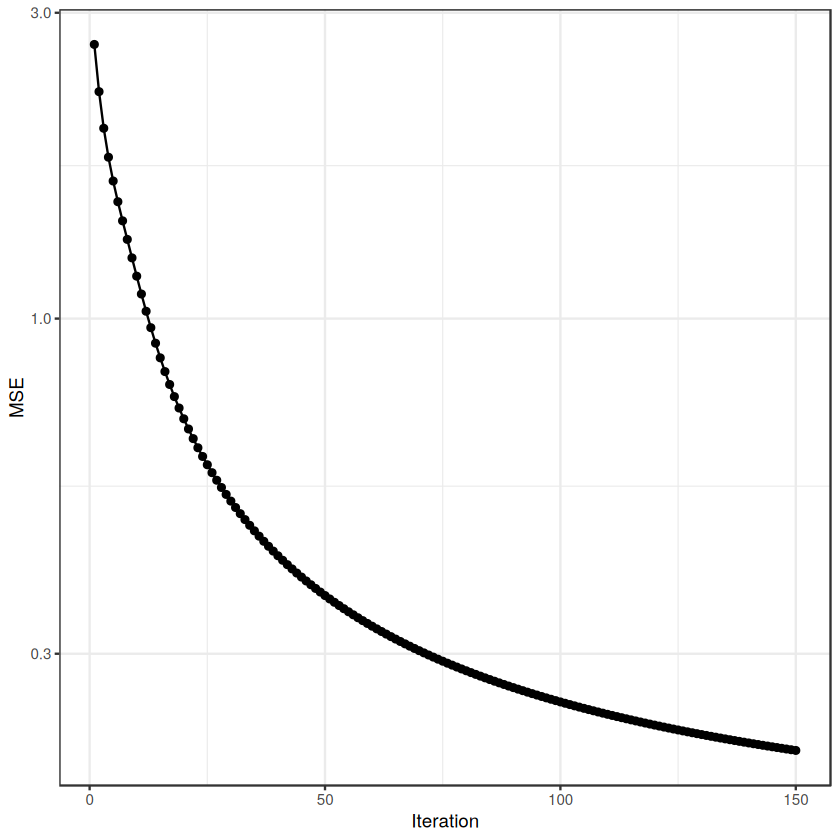

In [11]:
model$plotTracking()